In [151]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import gower

In [152]:
def data_access():
    project_id="model-lookups-mysql"
    client=bigquery.Client(project=project_id)
    query="""SELECT * FROM `model-lookups-mysql.leads_dmp.lewis_mlm_live`WHERE Lead_Status IN ('OTB', 'Decline')and deceased = 0 and dma_sensitive = 0 and bf_sensitive = 0 and credit_score > 300"""
    job=client.query(query)
    data=job.to_dataframe()
    return data
def select_columns(data):
    sc=['calculated_gender', 'calculated_age','have_personal_loan' ,
     'is_govt_employed', 'is_employed','credit_score', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview','interest_retail_furniture',
    'interest_retail_furniture_buy_cash', 'interest_retail_furniture_buy_credit']
    data=data[sc]
    cat_col_no_object=['is_govt_employed', 'is_employed', 
    'is_home_owners', 'is_car_owners' , 'is_under_debtreview','interest_retail_furniture','have_personal_loan',
    'interest_retail_furniture_buy_cash', 'interest_retail_furniture_buy_credit']
    data[cat_col_no_object]= data[cat_col_no_object].astype(str)
    others=[  'is_govt_employed', 'is_home_owners', 'is_car_owners' , 'is_under_debtreview','have_personal_loan',
            'interest_retail_furniture','interest_retail_furniture_buy_cash', 'interest_retail_furniture_buy_credit']
    recoding_others={'0': 'No', '1':'Yes'}
    data[others]=data[others].replace(recoding_others)
    recoding_employed={'0': 'Unknown/Unemployed', '1':'Employed'}   
    data['is_employed']=data['is_employed'].replace(recoding_employed)
    data = data[data['calculated_gender'] != 'U']
    return data
def remove_outliers(data):
    for column in data.select_dtypes(include=['number']).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data
cat_cols=['calculated_gender','have_personal_loan' ,
     'is_govt_employed', 'is_employed', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview','interest_retail_furniture',
    'interest_retail_furniture_buy_cash', 'interest_retail_furniture_buy_credit']
def encoded_data(data):
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False)
    one = encoder.fit_transform(data[cat_cols])
    one_df = pd.DataFrame(one, columns=encoder.get_feature_names_out(cat_cols), index=data.index)
    encoded = pd.concat([data, one_df], axis=1)
    encoded = encoded.drop(data[cat_cols], axis=1)
    return encoded

scaler = StandardScaler()
def scaled_data(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.fit_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data

def transform_back(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.inverse_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data

In [153]:
data=data_access()

In [154]:
selected_data=select_columns(data)

In [155]:
selected_data

,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview,interest_retail_furniture,interest_retail_furniture_buy_cash,interest_retail_furniture_buy_credit
0,M,33,No,No,Unknown/Unemployed,616,No,No,No,Yes,No,Yes
1,F,32,No,No,Unknown/Unemployed,693,No,No,No,No,No,No
2,F,34,Yes,No,Employed,547,No,No,Yes,Yes,No,Yes
3,M,33,No,No,Unknown/Unemployed,661,No,Yes,No,Yes,No,Yes
4,M,36,No,No,Unknown/Unemployed,586,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
242073,M,47,Yes,No,Employed,742,No,Yes,Yes,Yes,No,Yes
242074,M,48,Yes,No,Unknown/Unemployed,648,No,Yes,No,Yes,No,Yes
242075,F,50,No,No,Employed,609,Yes,Yes,No,Yes,No,Yes
242076,M,52,Yes,Yes,Employed,674,No,Yes,Yes,Yes,No,Yes


In [156]:
data_clean=remove_outliers(selected_data)

In [157]:
data_clean

,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview,interest_retail_furniture,interest_retail_furniture_buy_cash,interest_retail_furniture_buy_credit
0,M,33,No,No,Unknown/Unemployed,616,No,No,No,Yes,No,Yes
1,F,32,No,No,Unknown/Unemployed,693,No,No,No,No,No,No
2,F,34,Yes,No,Employed,547,No,No,Yes,Yes,No,Yes
3,M,33,No,No,Unknown/Unemployed,661,No,Yes,No,Yes,No,Yes
4,M,36,No,No,Unknown/Unemployed,586,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
242073,M,47,Yes,No,Employed,742,No,Yes,Yes,Yes,No,Yes
242074,M,48,Yes,No,Unknown/Unemployed,648,No,Yes,No,Yes,No,Yes
242075,F,50,No,No,Employed,609,Yes,Yes,No,Yes,No,Yes
242076,M,52,Yes,Yes,Employed,674,No,Yes,Yes,Yes,No,Yes


In [158]:
encode=encoded_data(data_clean)

In [159]:
scaled_data=scaled_data(encode)

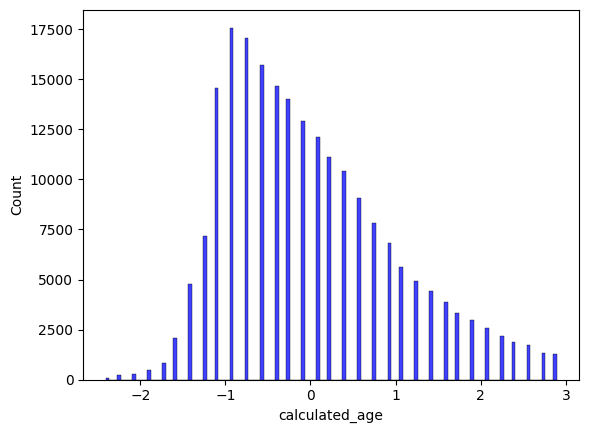

In [160]:
plot=sns.histplot(scaled_data['calculated_age'], color='b')

In [161]:
scaled_data

,calculated_age,credit_score,calculated_gender_F,calculated_gender_M,have_personal_loan_No,have_personal_loan_Yes,is_govt_employed_No,is_govt_employed_Yes,is_employed_Employed,is_employed_Unknown/Unemployed,...,is_car_owners_No,is_car_owners_Yes,is_under_debtreview_No,is_under_debtreview_Yes,interest_retail_furniture_No,interest_retail_furniture_Yes,interest_retail_furniture_buy_cash_No,interest_retail_furniture_buy_cash_Yes,interest_retail_furniture_buy_credit_No,interest_retail_furniture_buy_credit_Yes
0,-0.916010,0.189140,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,-1.081560,1.714250,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.750460,-1.177517,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,-0.916010,1.080438,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,-0.419359,-0.405058,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242073,1.401694,2.684774,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
242074,1.567244,0.822952,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
242075,1.898345,0.050494,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
242076,2.229445,1.337924,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


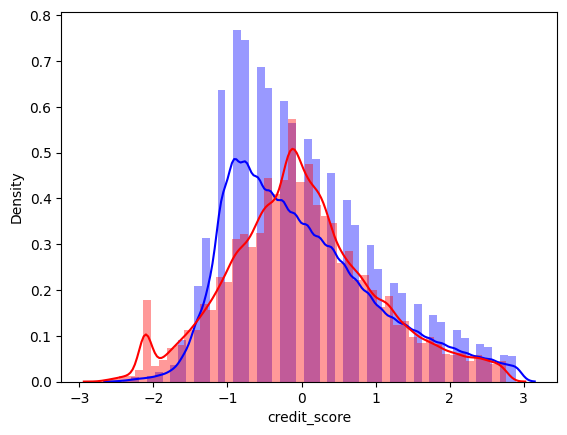

In [162]:
plot=sns.distplot(scaled_data['calculated_age'], color='b')
plot=sns.distplot(scaled_data['credit_score'], color='r')

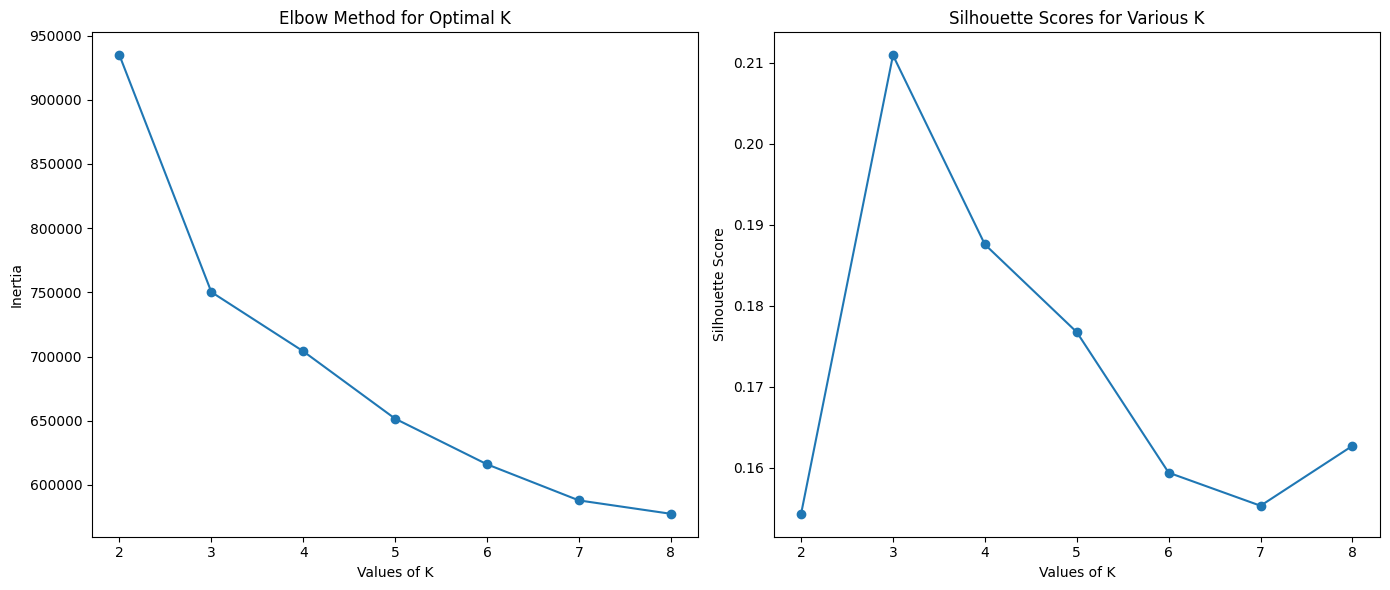

In [163]:
elbow_scores = {}
silhouette_scores = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=5, n_init='auto', tol=0.001, algorithm="lloyd", copy_x=True , random_state=0)
    kmeans.fit(scaled_data)
    elbow_scores[k] = kmeans.inertia_ 
    silhouette_scores[k] = silhouette_score(scaled_data, kmeans.labels_)  
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(list(elbow_scores.keys()), list(elbow_scores.values()), marker='o')
plt.xlabel("Values of K")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.subplot(1, 2, 2)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.xlabel("Values of K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Various K")
plt.tight_layout()
plt.show()

In [165]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=5, n_init=10, tol=0.0001, algorithm='lloyd', copy_x=True, random_state=0)
kmeans.fit(scaled_data)
clusters = kmeans.predict(scaled_data)
silhouette = silhouette_score(scaled_data, clusters)
print(f'Silhouette Score: {silhouette}')


Silhouette Score: 0.21338342910142685


In [166]:
import joblib
joblib.dump(kmeans, '/Users/senelisiwemuradzikwa/Desktop/Offernet/Client/Lewis/v2/kmeans_model.pkl')

['/Users/senelisiwemuradzikwa/Desktop/Offernet/Client/Lewis/v2/kmeans_model.pkl']

In [167]:
clusters

array([2, 0, 2, ..., 1, 1, 1], dtype=int32)

In [171]:
data_clean.insert(0, "Clusters", clusters, True)
data_clean

,Clusters,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview,interest_retail_furniture,interest_retail_furniture_buy_cash,interest_retail_furniture_buy_credit
0,2,M,33,No,No,Unknown/Unemployed,616,No,No,No,Yes,No,Yes
1,0,F,32,No,No,Unknown/Unemployed,693,No,No,No,No,No,No
2,2,F,34,Yes,No,Employed,547,No,No,Yes,Yes,No,Yes
3,2,M,33,No,No,Unknown/Unemployed,661,No,Yes,No,Yes,No,Yes
4,0,M,36,No,No,Unknown/Unemployed,586,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242073,1,M,47,Yes,No,Employed,742,No,Yes,Yes,Yes,No,Yes
242074,1,M,48,Yes,No,Unknown/Unemployed,648,No,Yes,No,Yes,No,Yes
242075,1,F,50,No,No,Employed,609,Yes,Yes,No,Yes,No,Yes
242076,1,M,52,Yes,Yes,Employed,674,No,Yes,Yes,Yes,No,Yes


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners', 'is_under_debtreview',
       'interest_retail_furniture', 'interest_retail_furniture_buy_cash',
       'interest_retail_furniture_buy_credit'],
      dtype='object')


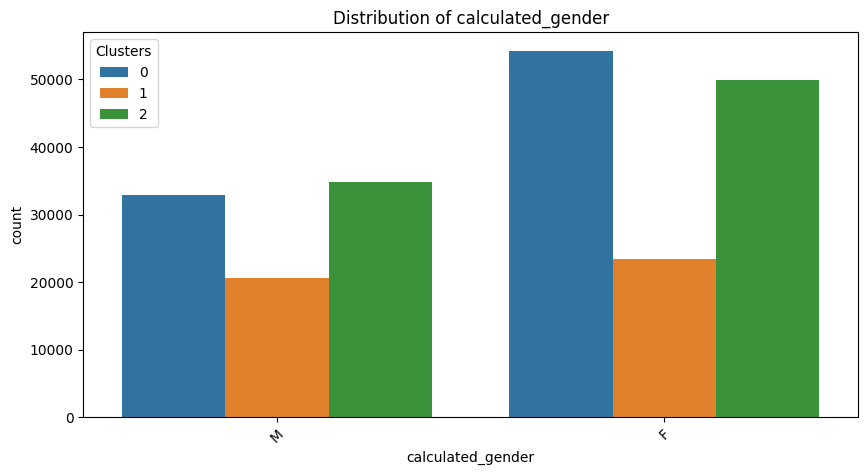

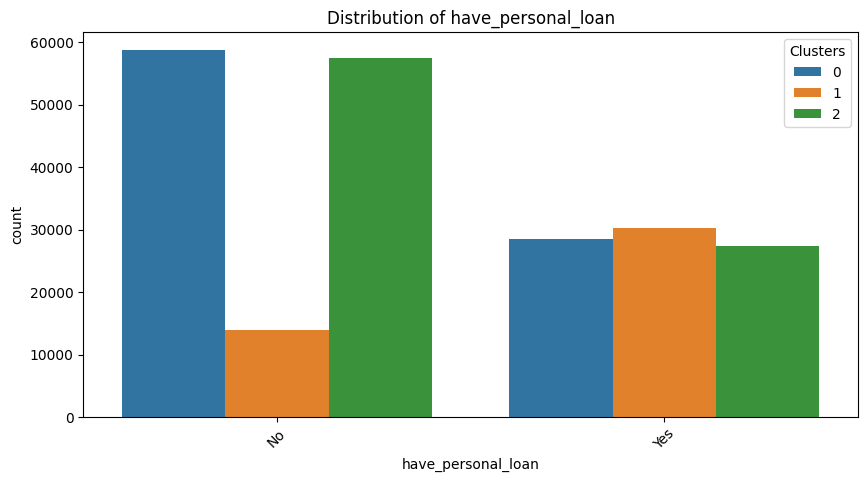

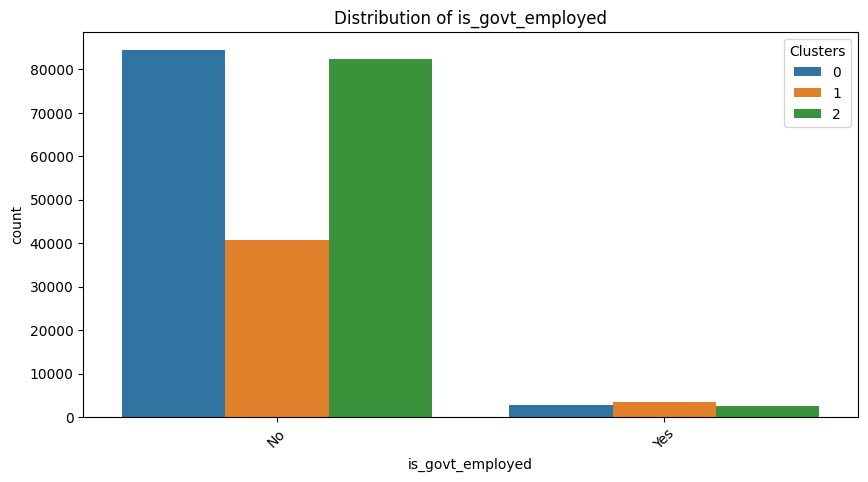

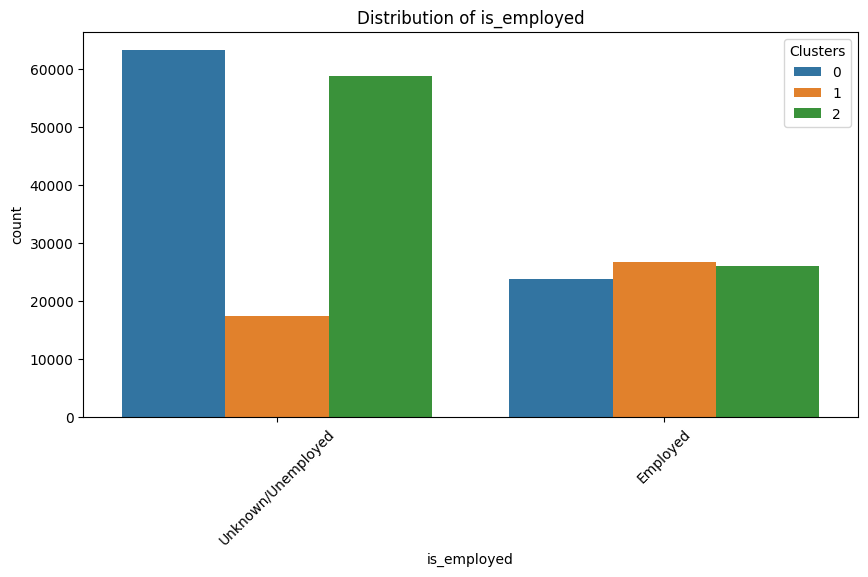

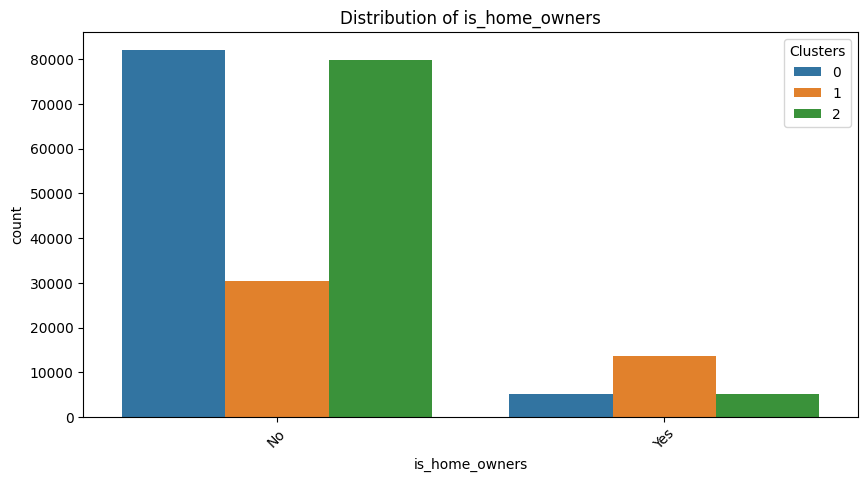

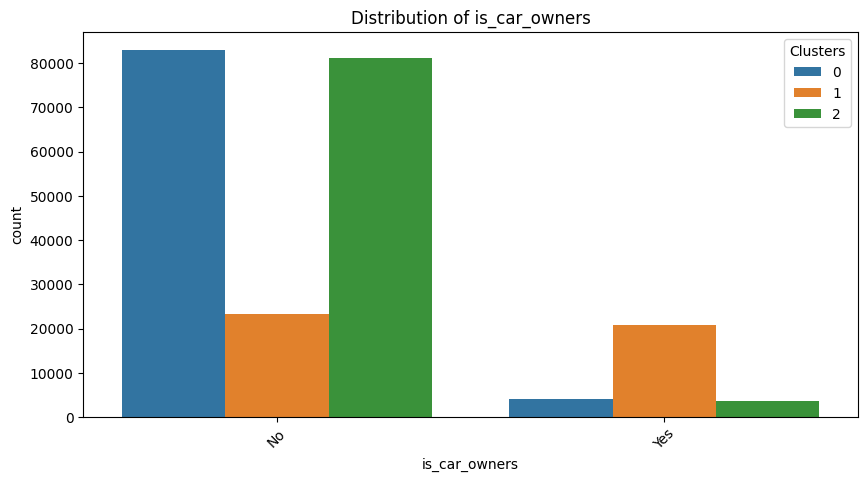

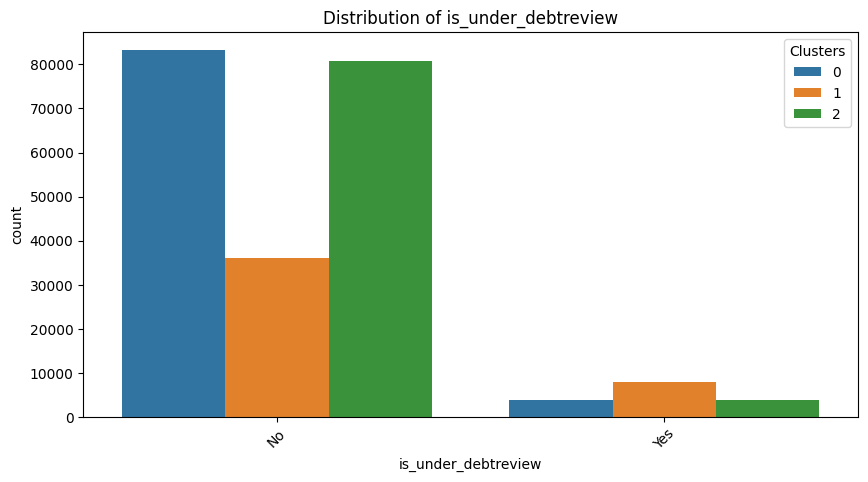

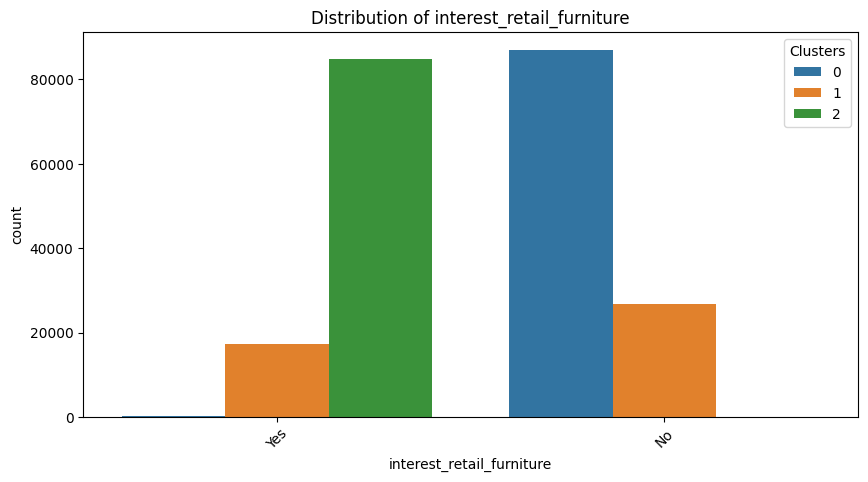

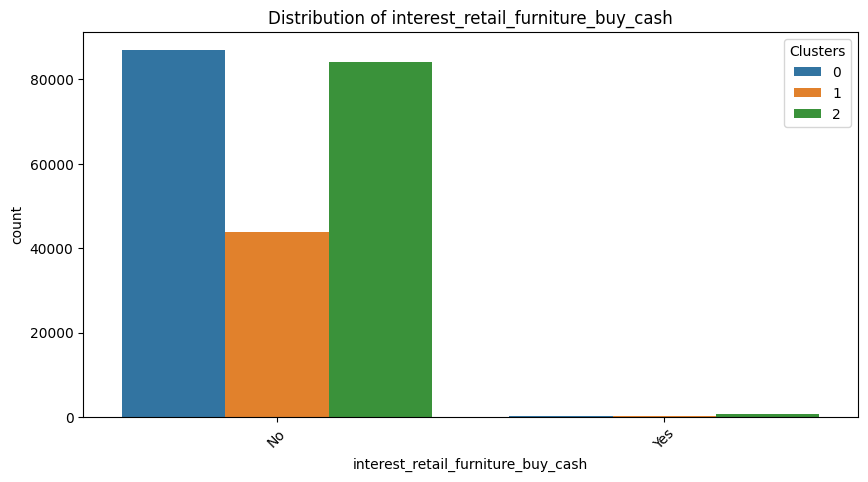

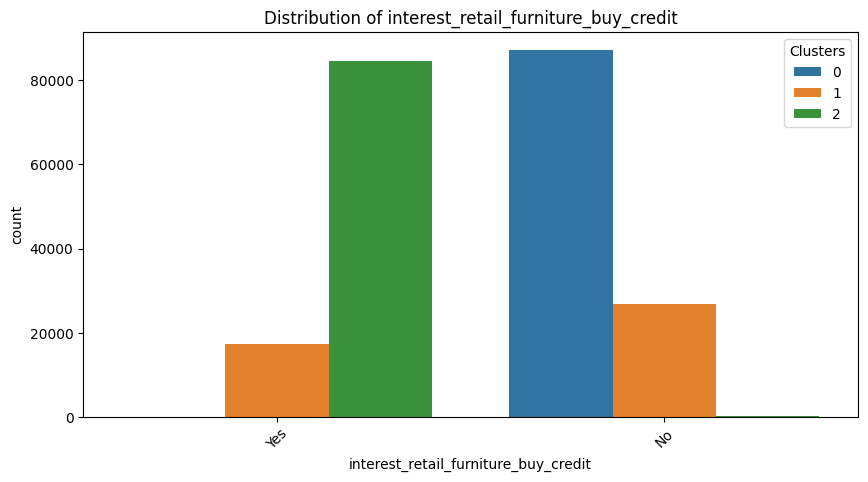

In [173]:
categorical_cols = data_clean.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col,hue='Clusters' ,data=data_clean)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

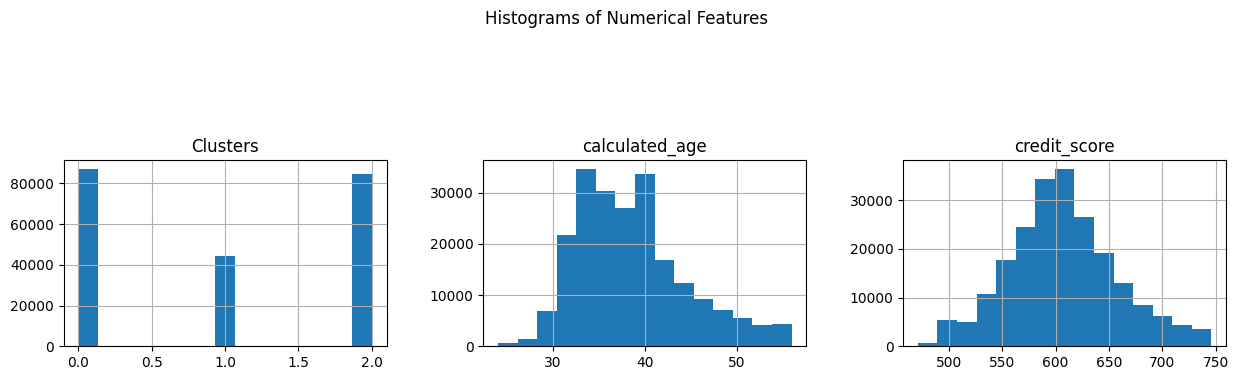

In [174]:
data_clean.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [175]:
filtered_data_0 = data_clean[data_clean['Clusters'] == 0]

In [176]:
filtered_data_0

,Clusters,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview,interest_retail_furniture,interest_retail_furniture_buy_cash,interest_retail_furniture_buy_credit
1,0,F,32,No,No,Unknown/Unemployed,693,No,No,No,No,No,No
4,0,M,36,No,No,Unknown/Unemployed,586,No,No,No,No,No,No
5,0,M,36,No,No,Employed,582,No,No,No,No,No,No
6,0,F,36,No,No,Unknown/Unemployed,519,No,No,No,No,No,No
9,0,F,40,No,No,Unknown/Unemployed,566,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242065,0,F,34,Yes,No,Employed,664,No,No,No,No,No,No
242066,0,F,34,Yes,No,Unknown/Unemployed,614,Yes,Yes,No,No,No,No
242067,0,F,35,Yes,No,Employed,476,No,No,No,No,No,No
242069,0,F,37,No,No,Employed,597,No,No,No,No,No,No


In [ ]:
# cat_cols_indices = [scaled_data.columns.get_loc(c) for c in scaled_data.columns if c in cat_cols]
# elbow_scores = {}
# silhouette_scores = {}
# for k in range(2, 9):
#     kproto = KPrototypes(n_clusters=k, init='Cao',n_jobs=-1, max_iter=10, n_init=1, verbose=1, random_state=0)
#     clusters = kproto.fit_predict(scaled_data.values, categorical=cat_cols_indices)
#     elbow_scores[k] = kproto.cost_
#     distance_matrix = gower.gower_matrix(scaled_data)
#     silhouette = silhouette_score(distance_matrix, clusters, metric='precomputed')
#     silhouette_scores[k] = silhouette 
#     print(f'Silhouette Score (Gower): {silhouette}')
    
# plt.plot(list(elbow_scores.keys()), list(elbow_scores.values()), marker='o')
# plt.xlabel("Values of K")
# plt.ylabel("Cost")
# plt.title("Elbow Method for Optimal K")
# plt.show()

# plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
# plt.xlabel("Values of K")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Scores for Different Values of K")
# plt.show()